# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#supress update on pandas regarding TargetEncoding
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data_raw = pd.read_csv('./vehicles.csv')
data = data_raw.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [2]:
#checking posting date
data.posting_date.str[:10].value_counts()

2021-05-03    35704
2021-05-04    30352
2021-04-30    28116
2021-05-01    26011
2021-04-29    21346
2021-04-28    19484
2021-04-23    18898
2021-04-27    17987
2021-05-02    17776
2021-04-26    16064
2021-04-22    14920
2021-04-24    13973
2021-04-21    12943
2021-04-16    11404
2021-04-20    11157
2021-04-19    10910
2021-04-15    10417
2021-04-14    10214
2021-04-17    10166
2021-04-09     9288
2021-04-08     8897
2021-04-12     8803
2021-04-13     8464
2021-04-25     8430
2021-04-07     7780
2021-04-05     7622
2021-04-10     7350
2021-04-06     7041
2021-04-18     6257
2021-04-11     5127
2021-04-04     3911
Name: posting_date, dtype: int64

In [3]:
#dropping irrelevant or mostly empty columns
#post year is all within 2 months, won't extract much information regarding posting time, will drop the column
data.drop(columns=['id', 'url', 'region', 'region_url', 'VIN', 'size', 
                   'image_url', 'county', 'lat', 'long', 'description', 'posting_date'],
          inplace=True)

#dropping rows with over half of empty columns
data.dropna(thresh=7, inplace=True)
#dropping duplicates
data.drop_duplicates(inplace=True)

cat_cols = data.select_dtypes(exclude=np.number).columns.to_list()

cont_cols = data.select_dtypes(include=np.number).columns.to_list()

## Target

In [4]:
from scipy.stats import iqr
#helper functions:
def filter_outliers(column):
    IQR = iqr(data[column])
    Q1 = np.quantile(data[column], 0.25)
    Q3 = np.quantile(data[column], 0.75)
    filter_outliers = (data[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
    return data[filter_outliers]

def inspect_normality(data, name, ax1, ax2):
    '''
    data - 1D array of data to analyze for normality
    name - name for the plot
    ax1, ax2 for plotting
    Returns:
    QQ plot,
    Box Plot,
    Prints D'Agostino and Pearson's P-value
    '''
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title(f'{name} Box Plot')
    sm.qqplot(data, line='q', ax=ax2, fit=True)
    ax2.set_title(f'{name} Q-Q plot')
    stat, p = normaltest(data)
    print(f'Normality P-Value: {p}')
    
data.price.describe()

count    2.985650e+05
mean     9.886200e+04
std      1.456658e+07
min      0.000000e+00
25%      5.500000e+03
50%      1.250000e+04
75%      2.459000e+04
max      3.736929e+09
Name: price, dtype: float64

Normality P-Value: 0.0


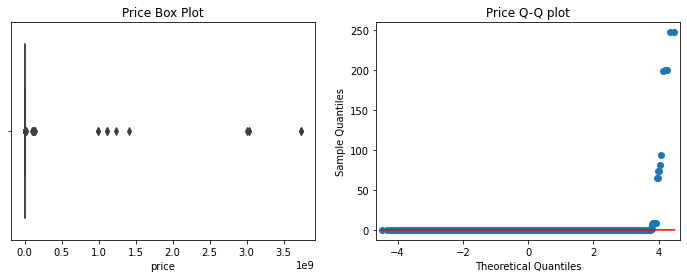

In [5]:
import statsmodels.api as sm
from scipy.stats import normaltest

#removing listings with <$100 price
data = data[data.price > 100]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
inspect_normality(data.price, 'Price', ax1, ax2)

Since the Price isn't normally distributed need to remove outliers using IQR

Normality P-Value: 0.0


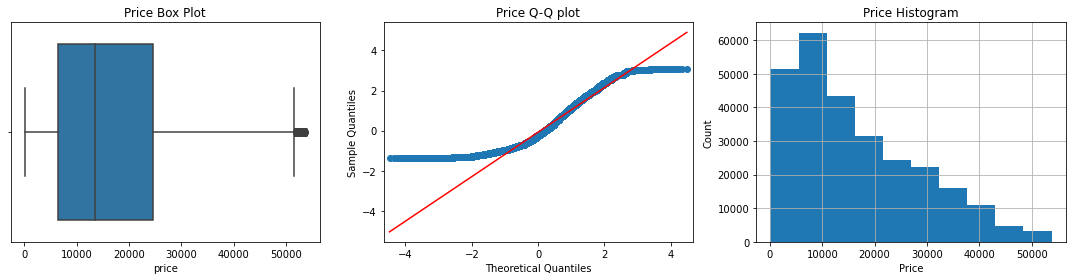

In [6]:
data = filter_outliers('price')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
inspect_normality(data.price,'Price', ax1, ax2)
data.price.hist(ax=ax3)
ax3.set_title('Price Histogram')
ax3.set_xlabel('Price')
ax3.set_ylabel('Count')

fig.tight_layout()

Data is still not Normal, but behaves much better

## Categorical Features

In [7]:
data[cat_cols].nunique()

manufacturer       42
model           27057
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
type               13
paint_color        12
state              51
dtype: int64

A ton of unique values for model feature, will deal with that separately.

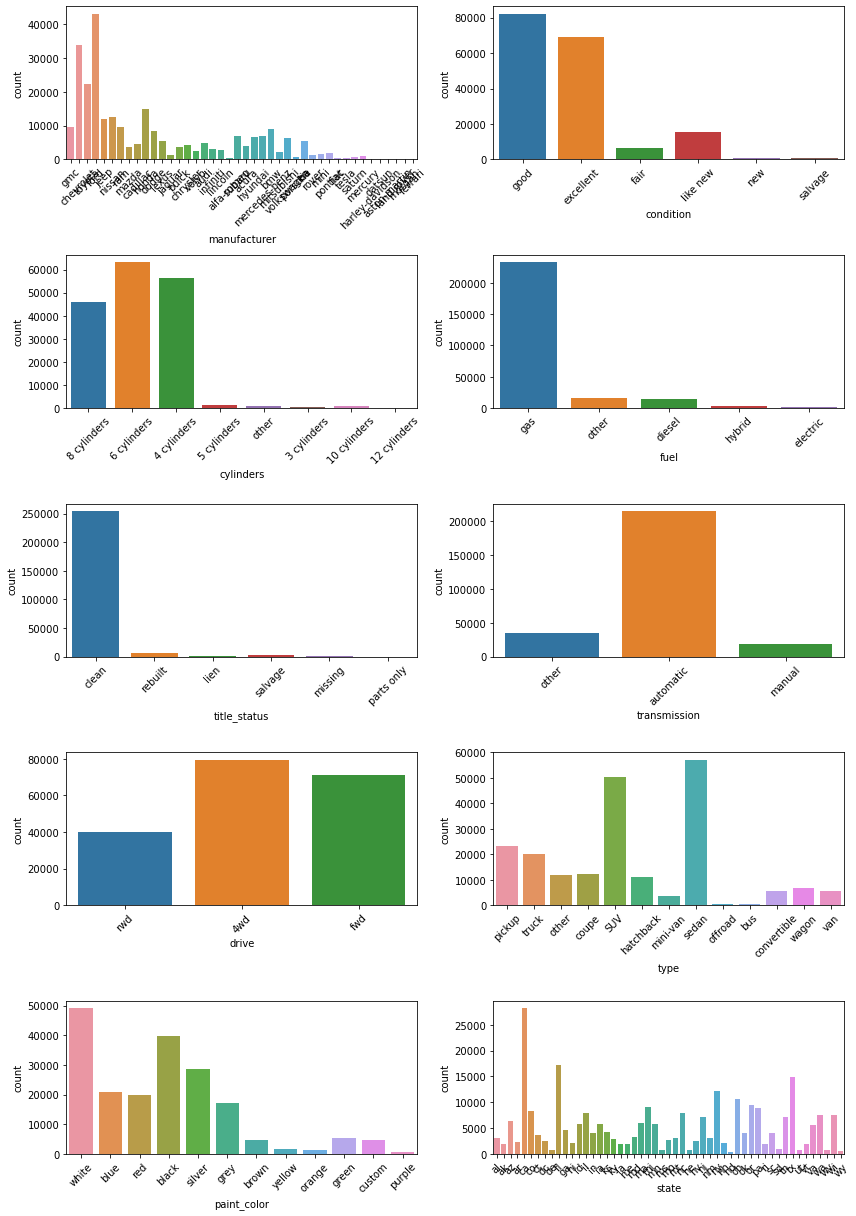

In [8]:
fig, axs = plt.subplots(5,2, figsize=(12, 17))
cat_cols.remove('model')
for col, ax1 in zip(cat_cols, axs.ravel()):
    #plotting counts for each column besides model
    sns.countplot(x=col, data=data, ax=ax1)
    ax1.tick_params(rotation=45, axis='x')
cat_cols.append('model')
fig.tight_layout()

Majority of the box plots are indicating outliers for each category on pricing

In [9]:
#dropping title status, overwhelming majority of values are clean.  That will not contribute to the model
data.drop(columns=['title_status'], inplace=True)
cat_cols.remove('title_status')

In [10]:
#checking duplicates that might have occurred once title was dropped
display(data[data.duplicated(keep=False)])
#dropping additional duplicates
data.drop_duplicates(inplace=True)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
25168,15995,2016.0,ford,transit t-150,NaN,6 cylinders,gas,8000.0,automatic,fwd,mini-van,white,ca
28924,15995,2016.0,ford,transit t-150,NaN,6 cylinders,gas,8000.0,automatic,fwd,mini-van,white,ca
32802,500,2013.0,nissan,altima,NaN,NaN,gas,130000.0,automatic,NaN,NaN,NaN,ca
44007,500,2013.0,nissan,altima,NaN,NaN,gas,130000.0,automatic,NaN,NaN,NaN,ca
59520,10999,2016.0,chevrolet,cruze ls sedan 4d,excellent,4 cylinders,gas,64152.0,automatic,NaN,sedan,NaN,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377259,3550,2000.0,bmw,z3,excellent,6 cylinders,gas,154455.0,automatic,rwd,convertible,NaN,tx
377424,2450,2002.0,ford,mustang,excellent,6 cylinders,gas,0.0,manual,rwd,coupe,NaN,tx
382444,3500,2011.0,ford,f-150,NaN,NaN,gas,210826.0,automatic,NaN,NaN,NaN,tx
419795,30000,2018.0,kia,stinger gt,excellent,6 cylinders,gas,32475.0,automatic,4wd,coupe,grey,wi


In [11]:
#Users might not fill out all the information every time, therefore 
#There are more duplicates in the data set still

#adding VIN from the original data set.  if the same VIN shows up, it's the same vehicle.  
#The data is only for a 2 month span from post date analysis, therefore same VIN showing up with same 
#year and price is the same vehicle, will drop those.
data = data.join(data_raw['VIN'])

dup_filt = (data.duplicated(subset=['price', 'year', 'manufacturer', 'model',
                                   'odometer', 'state', 'VIN'])) & (~data.VIN.isna())
duplicated_indecies = data[dup_filt].index

#Can drop VIN now and duplicated rows
data.drop(index=duplicated_indecies, columns='VIN', inplace=True)

In [12]:
#Now inspecting duplicates that had VIN missing.
#In general if the price, year, manufacturer, odometer, 
#trasmission, state and color are the same, it should be the same posting.  Color is sometimes missing
subset = ['price', 'year', 'manufacturer', 'odometer', 'transmission','state', 'paint_color']
duplicated_indecies = data.duplicated(subset=subset, keep=False)
display(data[duplicated_indecies].sort_values(['year', 'manufacturer', 'odometer']))

#dropping the rows identified above
data.drop_duplicates(subset=subset, inplace=True)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
188939,18500,1923.0,ford,t bucket,new,8 cylinders,gas,2500.0,automatic,rwd,convertible,NaN,ma
191351,18500,1923.0,ford,t bucket,like new,8 cylinders,gas,2500.0,automatic,rwd,convertible,NaN,ma
193319,18500,1923.0,ford,t-bucket,like new,8 cylinders,gas,2500.0,automatic,rwd,convertible,NaN,ma
9681,11500,1928.0,chevrolet,coupe,fair,4 cylinders,gas,55752.0,manual,rwd,coupe,yellow,az
17077,11500,1928.0,chevrolet,coupe,fair,4 cylinders,gas,55752.0,manual,NaN,NaN,yellow,az
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104181,41000,2021.0,NaN,2021,new,8 cylinders,gas,168.0,manual,rwd,coupe,blue,fl
402410,24998,2022.0,mitsubishi,eclipse cross,new,NaN,gas,10.0,automatic,fwd,NaN,black,wa
403267,24998,2022.0,mitsubishi,eclipse cross,new,NaN,gas,10.0,automatic,NaN,NaN,black,wa
271885,1000,2022.0,NaN,all,NaN,NaN,gas,1000.0,other,NaN,NaN,NaN,ny


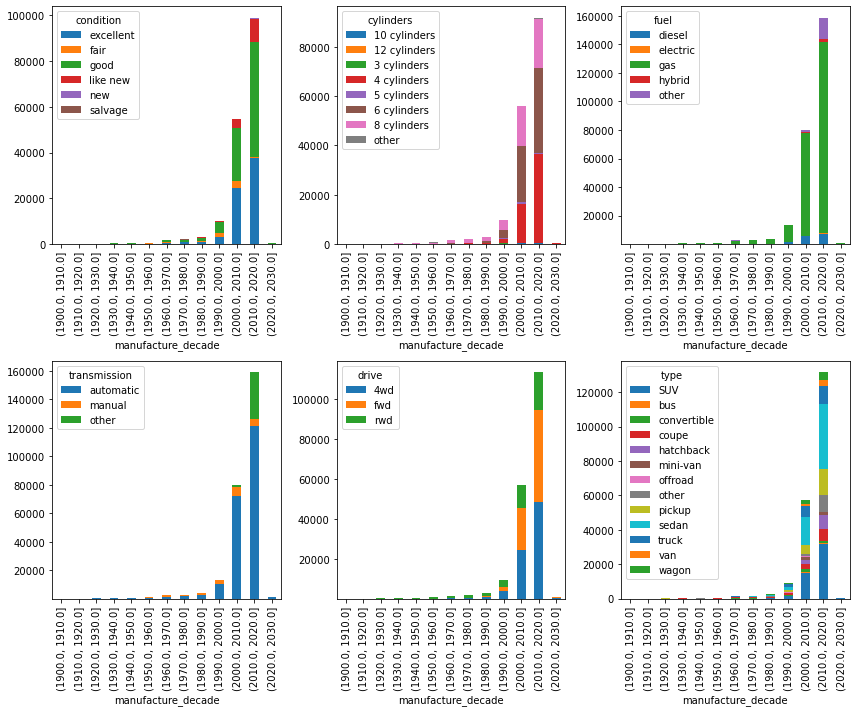

In [13]:
#checking trends per decades
bin_width = 10
min_year = data.year.min()
max_year = data.year.max()
bins = np.arange(min_year, max_year+bin_width, bin_width)
data['manufacture_decade'] = pd.cut(data.year, bins=bins)
fig, axs = plt.subplots(2,3, figsize=(12, 10))
analysis_cols = ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type']

for col, ax in zip(analysis_cols, axs.ravel()):
    plot_data = data.value_counts(['manufacture_decade', col]).unstack()
    plot_data.plot(kind='bar', stacked=True, ax=ax)

data.drop(columns='manufacture_decade', inplace=True)
fig.tight_layout()

Fuel type is mainly Gas, therefore won't have much impact on the model, will keep for now and tune during feature selection

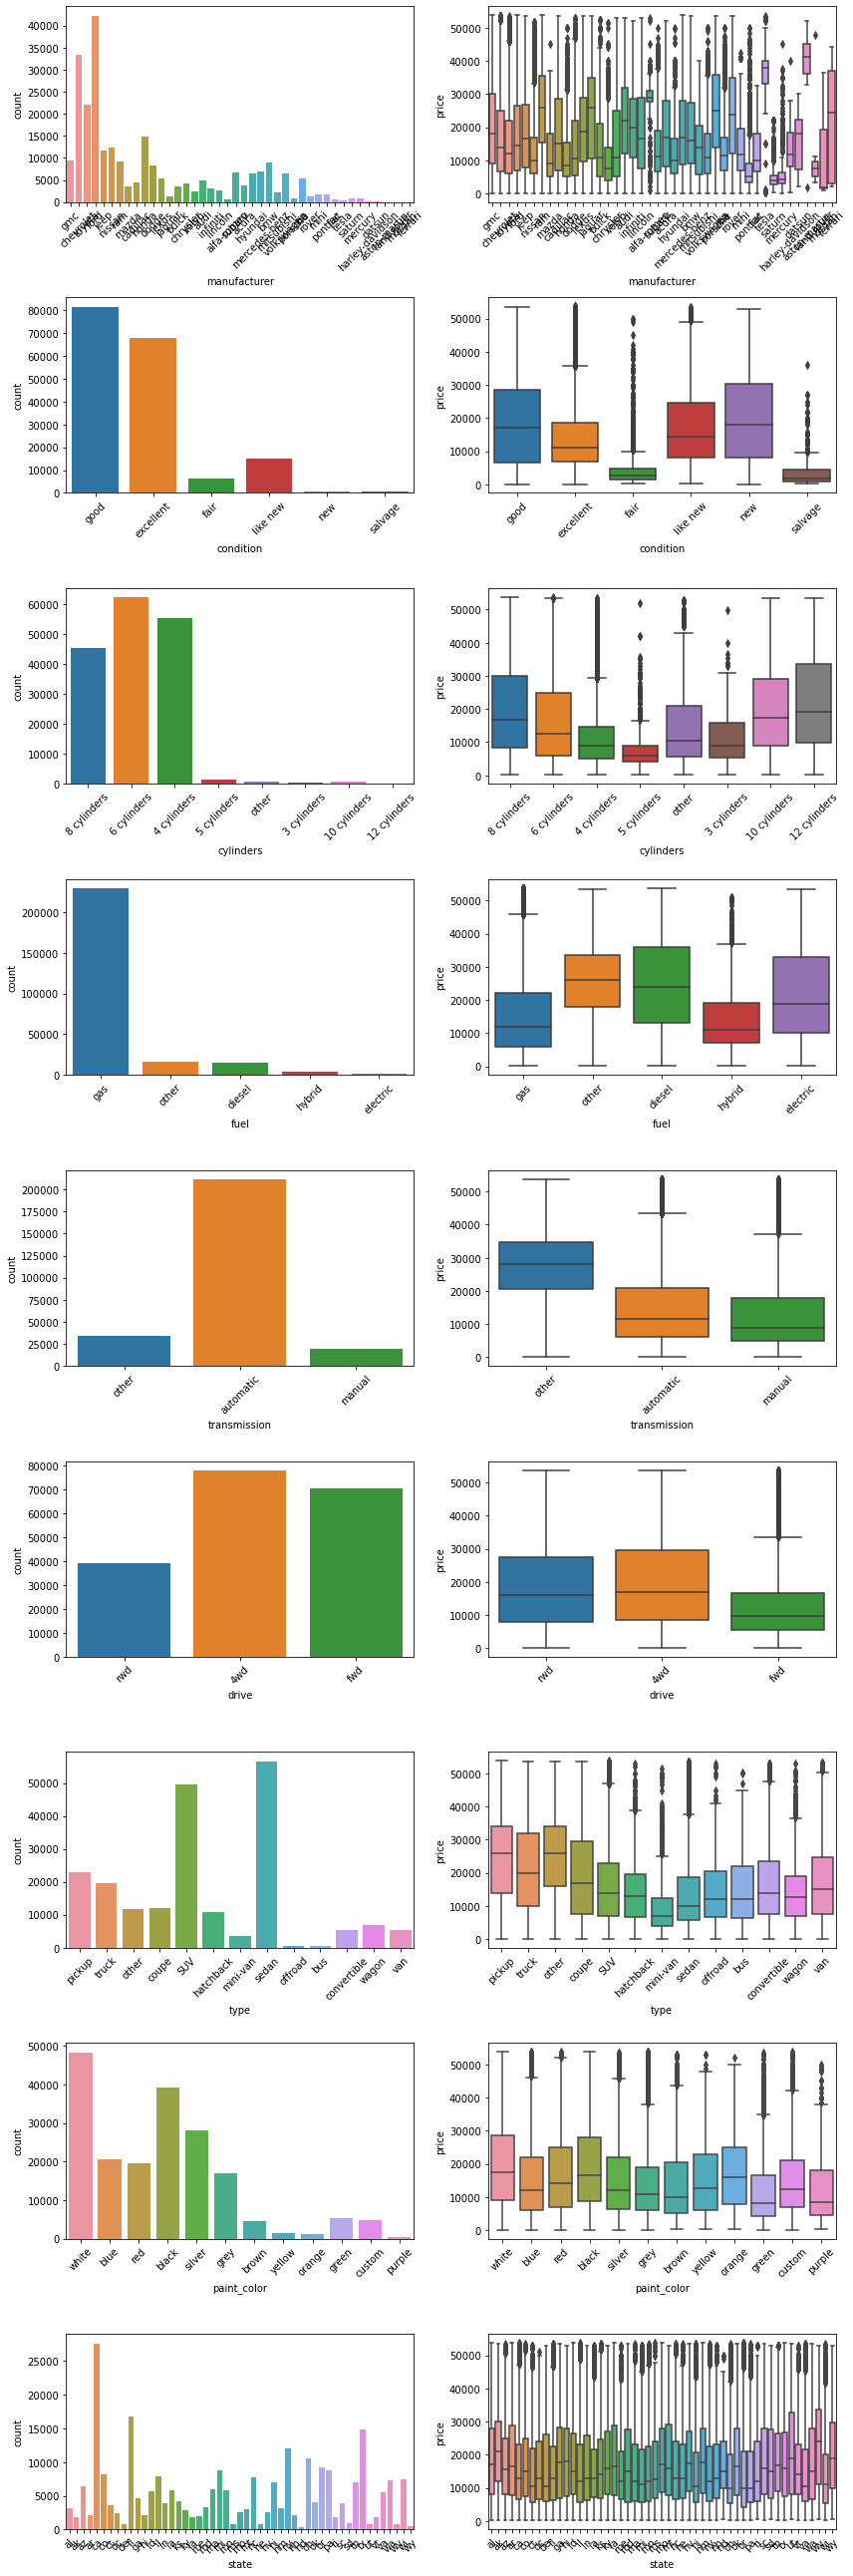

In [14]:
fig, axs = plt.subplots(9,2, figsize=(12, 36))
cat_cols.remove('model')
for col, (ax1, ax2) in zip(cat_cols, axs):
    #plotting counts for each column besides model
    sns.countplot(x=col, data=data, ax=ax1)
    sns.boxplot(y='price', x=col, data=data, ax=ax2)
    ax1.tick_params(rotation=45, axis='x')
    ax2.tick_params(rotation=45, axis='x')
cat_cols.append('model')
fig.tight_layout()

Paint color has steady counts and medians are nearly the same across the board, most likely won't impact the model as well

In [15]:
#inspecting empty manufacturers
data[data.manufacturer.isna()]

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
97,15990,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,gas,29652.0,other,fwd,hatchback,blue,al
122,6800,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,automatic,rwd,bus,yellow,al
135,14990,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,gas,65203.0,other,fwd,hatchback,red,al
137,2500,1966.0,NaN,1966 C-30 1 ton,good,6 cylinders,gas,47000.0,manual,rwd,pickup,brown,al
155,8990,2013.0,NaN,smart fortwo Passion Hatchback,good,NaN,gas,59072.0,automatic,rwd,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426843,21999,2017.0,NaN,2017,NaN,NaN,gas,51000.0,automatic,NaN,NaN,NaN,wy
426846,41999,2015.0,NaN,2015,NaN,NaN,gas,126000.0,automatic,NaN,NaN,NaN,wy
426862,27590,2018.0,NaN,Genesis G80 3.8 Sedan 4D,good,6 cylinders,gas,36138.0,other,NaN,sedan,black,wy
426863,25590,2017.0,NaN,Genesis G80 3.8 Sedan 4D,good,6 cylinders,gas,37608.0,automatic,rwd,sedan,white,wy


In [16]:
init_empty_manuf = data.manufacturer.isna().sum()
#some of the empty manufacturers have models that have manufacturers in previous rows
#can use that to fill empty values in
filt = (~data.manufacturer.isna()) & (~data.model.isna())
#converting to lower strings for better matching later
data['manufacturer'] = data.manufacturer.str.lower()
data['model'] = data.model.str.lower()
#model has ton of words, but first word is usually model name
data['mapped_model'] = data.model.str.split().str[0]
data['mapped_model'] = data.mapped_model.str.replace(',','')

manufacturer_mapping = data.loc[filt,['mapped_model', 'manufacturer']]
#now grouping by model since they won't be unique and picking most common manufacturer
manufacturer_mapping = manufacturer_mapping.groupby('mapped_model').agg(pd.Series.mode)
#could have multiple modes, need to drop any indecies with that
drop_index = manufacturer_mapping[manufacturer_mapping.manufacturer.map(type).eq(type(np.array([])))].index
manufacturer_mapping.drop(index=drop_index, inplace=True)

#now joining
data = data.join(manufacturer_mapping, on='mapped_model', rsuffix='_mapped')
data['manufacturer'].fillna(data['manufacturer_mapped'], inplace=True)
final_empty_manuf = data.manufacturer.isna().sum()
data.drop(columns=['mapped_model', 'manufacturer_mapped'], inplace=True)
print(f'Filled in {init_empty_manuf - final_empty_manuf} manufacturers')

Filled in 4390 manufacturers


## Continuous Features

<AxesSubplot:>

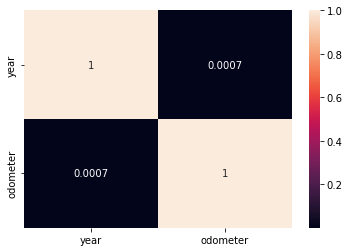

In [17]:
#dropping price as continuous column since it's the target variable
cont_cols.remove('price')

#checking for correlations between continous variables
corr = data[cont_cols].fillna(0).corr()
ordered = corr.sum().sort_values().index.to_list()
sns.heatmap(corr.loc[ordered, ordered], annot=True)

Only 2 continous variables with little correlation between.

,year,odometer
count,265066.000000,2.645220e+05
mean,2009.928674,1.057617e+05
std,10.416490,2.201662e+05
min,1900.000000,0.000000e+00
25%,2007.000000,4.364400e+04
50%,2013.000000,9.421400e+04
75%,2016.000000,1.416008e+05
max,2022.000000,1.000000e+07


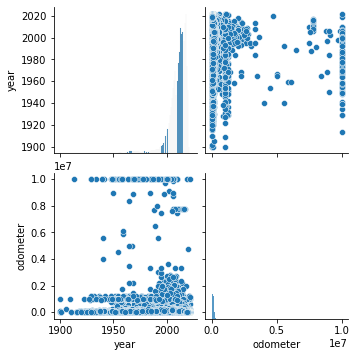

In [18]:
sns.pairplot(data[cont_cols])
data[cont_cols].describe()

Outliers present in year column and odometer, need to inspect those

Normality P-Value: 0.0
Normality P-Value: 0.0


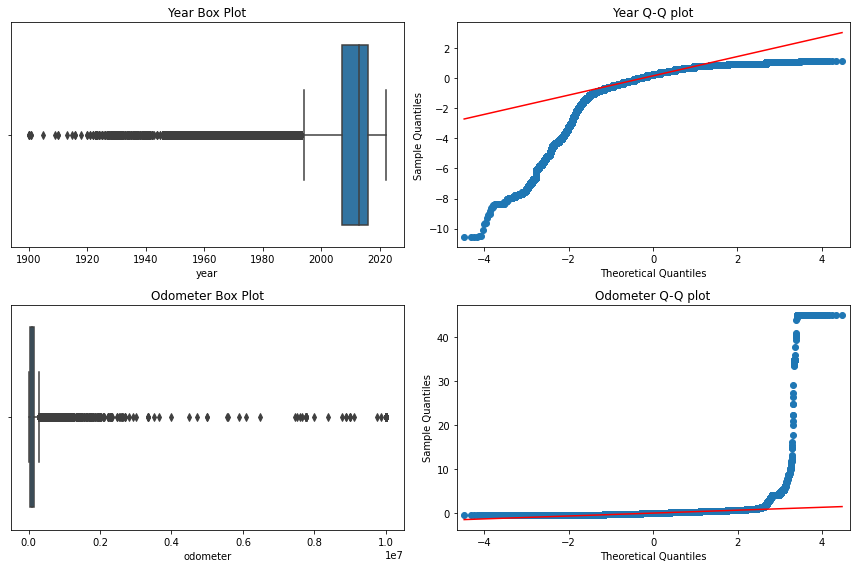

In [19]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,8))
inspect_normality(data.loc[~data.year.isna(), 'year'], 'Year', *ax1)
inspect_normality(data.loc[~data.odometer.isna(), 'odometer'], 'Odometer', *ax2)
fig.tight_layout()

Both variables are plagued by outliers and bad values

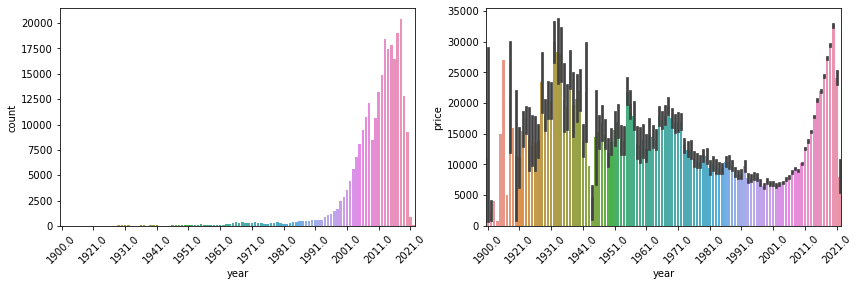

In [20]:
def change_tick_freq(ax, freq=3):
    ticks = ax.get_xticks()[::freq]
    ticks_labels = ax.get_xticklabels()[::freq]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_labels)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))
sns.countplot(x='year', data=data, ax=ax1)
ax1.tick_params(axis='x', rotation=45)
sns.barplot(x='year', y='price', data=data, ax=ax2)
ax2.tick_params(axis='x', rotation=45)

change_tick_freq(ax1, 10)
change_tick_freq(ax2, 10)

The latter dates are reasonable and have more of a gaussian distribution, however the lower end is skewed. 

In [21]:
display(data[data.year==1900])

#need to drop anythig with 1900 year
data.drop(index=data[data.year==1900].index, inplace=True)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
42454,38250,1900.0,acura,rdx,new,4 cylinders,gas,4500.0,automatic,4wd,SUV,silver,ca
123023,4500,1900.0,NaN,cushman white van,excellent,NaN,gas,2136.0,manual,NaN,NaN,white,ga
269472,998,1900.0,NaN,any,NaN,NaN,other,123456.0,other,NaN,other,NaN,ny
398032,500,1900.0,dodge,rampage,salvage,NaN,gas,999999.0,other,fwd,other,NaN,va


In [22]:
data.isna().sum()

price               0
year              618
manufacturer     6645
model            3393
condition       93151
cylinders       99152
fuel             1325
odometer         1162
transmission      955
drive           77704
type            60352
paint_color     74536
state               0
dtype: int64

In [23]:
#now inspecting odometer
#create a string column to compare characters.  many entries have repeated charters 111111, 999999, etc.
data['str_odometer'] = data.odometer.fillna(10).astype('int').astype('str')
#converting strings to sets, if same number is repeated set len would be 1
filt = data.str_odometer.apply(lambda x: len(set(x))==1)
#setting the values to nan
display(data[filt])
data.loc[filt, 'odometer'] = np.nan

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,str_odometer
101,12990,1968.0,volvo,NaN,NaN,NaN,gas,99999.0,manual,NaN,NaN,NaN,al,99999
245,5500,1974.0,mercedes-benz,1929 ssk replica,good,4 cylinders,gas,9999.0,automatic,rwd,convertible,yellow,al,9999
455,22500,1929.0,ford,NaN,NaN,NaN,gas,9999999.0,automatic,NaN,NaN,NaN,al,9999999
562,27990,2014.0,ram,2500 4x4,like new,6 cylinders,diesel,2222222.0,automatic,4wd,truck,white,al,2222222
616,17990,2018.0,ford,edge sel,like new,6 cylinders,gas,1111111.0,automatic,fwd,SUV,blue,al,1111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425160,1800,2005.0,NaN,hackney beverage body,good,NaN,other,1.0,other,NaN,NaN,NaN,wi,1
425767,9770,2007.0,NaN,dutchman freedom spirit,NaN,NaN,other,1.0,other,NaN,NaN,NaN,wi,1
426106,850,1987.0,ram,NaN,salvage,NaN,gas,9999999.0,automatic,NaN,NaN,NaN,wi,9999999
426108,1500,1993.0,ram,NaN,NaN,NaN,gas,999999.0,automatic,NaN,NaN,NaN,wi,999999


In [24]:
#now need to identify rows with odometer values 123456 etc.
def check_seq_numer(x):
    #x - string
    if len(x) > 2:
        #milage could be 12, or 23, but 123 is much less likely
        seq=[int(i) for i in x]
        return seq == list(range(min(seq), max(seq)+1))
    else:
        return False

filt = data.str_odometer.apply(check_seq_numer)
display(data[filt])
data.loc[filt, 'odometer'] = np.nan
data.drop(columns='str_odometer', inplace=True)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,str_odometer
237,20000,1979.0,chevrolet,malibu,like new,8 cylinders,gas,1234.0,automatic,rwd,NaN,black,al,1234
1016,12500,1946.0,NaN,autocar flatbed truck,fair,6 cylinders,gas,123.0,manual,NaN,NaN,NaN,al,123
2218,6500,1986.0,chevrolet,k10 4x4,good,8 cylinders,gas,123456.0,automatic,4wd,pickup,brown,al,123456
2439,28999,1955.0,chevrolet,210,good,8 cylinders,gas,1234.0,automatic,rwd,sedan,orange,al,1234
2531,6500,1984.0,chevrolet,k5 blazer,fair,8 cylinders,gas,123456.0,automatic,4wd,SUV,black,al,123456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424918,123,2015.0,ford,explorer,like new,6 cylinders,gas,1234.0,automatic,4wd,pickup,grey,wi,1234
424919,123,2013.0,chevrolet,suburban,like new,8 cylinders,gas,1234.0,automatic,4wd,pickup,black,wi,1234
424923,123,2011.0,jeep,grand cherokee,like new,8 cylinders,gas,1234.0,automatic,4wd,pickup,green,wi,1234
425379,10000,1967.0,pontiac,firebird,NaN,NaN,gas,12345.0,other,NaN,NaN,NaN,wi,12345


In [25]:
#now checking if there are rows with majority Nan
data[(data.isna().sum(1) > 5)]

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
101,12990,1968.0,volvo,NaN,NaN,NaN,gas,NaN,manual,NaN,NaN,NaN,al
414,39900,2015.0,lincoln,NaN,NaN,NaN,gas,51.0,automatic,NaN,NaN,NaN,al
455,22500,1929.0,ford,NaN,NaN,NaN,gas,NaN,automatic,NaN,NaN,NaN,al
696,16937,2011.0,NaN,forde450,NaN,NaN,gas,27000.0,automatic,NaN,NaN,NaN,al
1231,10000,1970.0,volvo,NaN,NaN,NaN,gas,NaN,manual,NaN,NaN,NaN,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426693,39999,2017.0,jeep,NaN,NaN,NaN,gas,7000.0,automatic,NaN,NaN,NaN,wy
426814,18750,2005.0,NaN,"gmc, ford, freightliner & more",NaN,NaN,diesel,161087.0,automatic,NaN,NaN,NaN,wy
426835,34999,2015.0,NaN,2015,NaN,NaN,gas,116000.0,automatic,NaN,NaN,NaN,wy
426841,16999,2014.0,NaN,2014,NaN,NaN,gas,89000.0,automatic,NaN,NaN,NaN,wy


Normality P-Value: 0.0


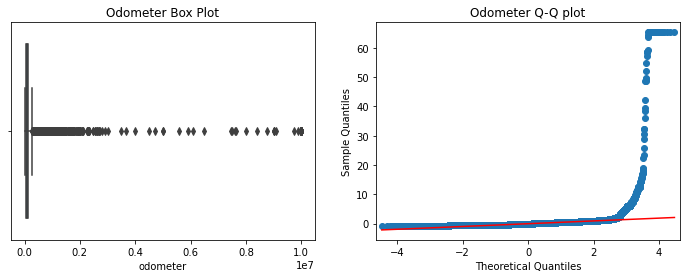

In [26]:
#nothing more we can drop, now will review odometer normality
fig, axs = plt.subplots(1,2, figsize=(12,4))
inspect_normality(data.loc[~data.odometer.isna(), 'odometer'], 'Odometer', *axs)

# Preprocessing / Feature Extraction

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, Normalizer
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

target_cols = ['manufacturer', 'model', 'state']
cat_cols = list(set(cat_cols) - set(target_cols))

#filling in missing categorical features with NA values
data.fillna({key : 'NA' for key in target_cols + cat_cols}, inplace=True)
X = data[cat_cols + cont_cols + target_cols]
y=data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('cont', SimpleImputer(strategy='median'), cont_cols)])

model = Pipeline([('ct', ct), ('scaler', Normalizer()), ('model', LinearRegression())])
nrm_scaler = cross_val_score(model, X_train, y_train, cv=15, n_jobs=-1).mean()

model.steps[1] = ('scaler', StandardScaler(with_mean=False))
std_scaler = cross_val_score(model, X_train, y_train, cv=15, n_jobs=-1).mean()

model.steps.pop(1)
wo_scaler = cross_val_score(model, X_train, y_train, cv=15, n_jobs=-1).mean()

print('Base Scores')
print(f'Normalizer: {nrm_scaler:.3f}')
print(f'StandardScaler: {std_scaler:.3f}')
print(f'W/O Scaler: {wo_scaler:.3f}')

Base Scores
Normalizer: 0.632
StandardScaler: 0.582
W/O Scaler: 0.581


Using Normalized improves the score, but it projects all the data to the circle, therefore not advised in this scenario.  

Scaler makes no impact on the model since there is no regulization, as expected.
  
Will use Kmeans and GaussianMixture to derive new features.  It will not impact normalizer score, but could benefit Standard Scaler results.

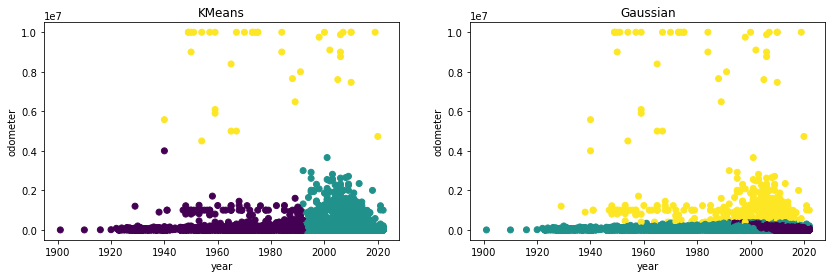

In [28]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def extract_clusters(X_trn, X_tst, extractor, categorical=False, cols=['year', 'odometer']):
    '''
    Extracts features from X_tst and adds to X_trn based on extractor.  Accepts data with missing values.
    
    Inputs:
    X_tst, X_trn - test and train sets, will return new copies with added features (pandas DF)
    extractor - KMeans or Gaussian, pass not fitted.  Needs to implement fit, transform/predict
    categorical - add clusters as categories or as distances between clusters.
                  True - extractor needs to implement predict
                  False - extractor needs to implement transform
    cols - which columns to use extractor on
    
    Returns - updated X_train and X_test
    '''
    #need to fill in missing values and scale for Kmeans
    preprocess = Pipeline([('imputer', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

    X_trn_trans = preprocess.fit_transform(X_trn[cols])
    X_tst_trans = preprocess.transform(X_tst[cols])    
    extractor.fit(X_trn_trans)
    if categorical:
        trn_cluster = extractor.predict(X_trn_trans)
        trn_cluster = pd.Series(trn_cluster, index=X_trn.index, name='cluster')
        tst_cluster = extractor.predict(X_tst_trans)
        tst_cluster = pd.Series(tst_cluster, index=X_tst.index, name='cluster')
    else:
        trn_cluster = extractor.transform(X_trn_trans)
        tst_cluster = extractor.transform(X_tst_trans)
        clusters = trn_cluster.shape[1]
        col_names = [f'cluster_{i}' for i in range(clusters)]
        trn_cluster = pd.DataFrame(trn_cluster, index=X_trn.index, columns=col_names)
        
        tst_cluster = pd.DataFrame(tst_cluster, index=X_tst.index, columns=col_names)
    X_trn_final = pd.concat([X_trn, trn_cluster], axis=1)
    X_tst_final = pd.concat([X_tst, tst_cluster], axis=1)
    return X_trn_final, X_tst_final

x_train_kmeans, _ = extract_clusters(X_train, X_test, 
                                     KMeans(n_clusters=3), categorical=True)

x_train_gauss, _ = extract_clusters(X_train, X_test, 
                                    GaussianMixture(n_components=3), categorical=True)

fig, axs = plt.subplots(1,2, figsize=(14,4))
for title, x, ax in zip(['KMeans', 'Gaussian'], [x_train_kmeans, x_train_gauss], axs.ravel()):
    ax.scatter(x='year', y='odometer', data=x, c='cluster')
    ax.set_xlabel('year')
    ax.set_ylabel('odometer')
    ax.set_title(title)

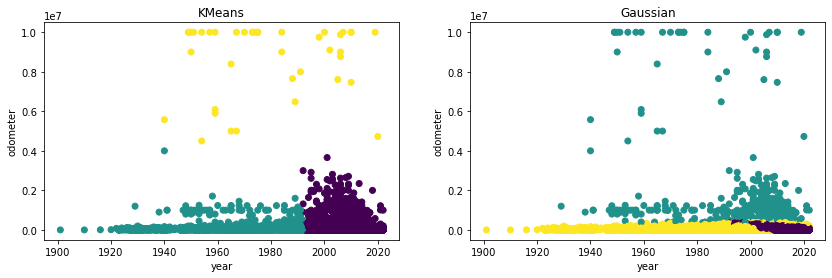

In [86]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def extract_clusters(X_trn, X_tst, extractor, categorical=False, cols=['year', 'odometer']):
    '''
    Extracts features from X_tst and adds to X_trn based on extractor.  Accepts data with missing values.
    
    Inputs:
    X_tst, X_trn - test and train sets, will return new copies with added features (pandas DF)
    extractor - KMeans or Gaussian, pass not fitted.  Needs to implement fit, transform/predict
    categorical - add clusters as categories or as distances between clusters.
                  True - extractor needs to implement predict
                  False - extractor needs to implement transform
    cols - which columns to use extractor on
    
    Returns - updated X_train and X_test
    '''
    #need to fill in missing values and scale for Kmeans
    preprocess = Pipeline([('imputer', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

    X_trn_trans = preprocess.fit_transform(X_trn[cols])
    X_tst_trans = preprocess.transform(X_tst[cols])    
    extractor.fit(X_trn_trans)
    if categorical:
        trn_cluster = extractor.predict(X_trn_trans)
        trn_cluster = pd.Series(trn_cluster, index=X_trn.index, name='cluster')
        tst_cluster = extractor.predict(X_tst_trans)
        tst_cluster = pd.Series(tst_cluster, index=X_tst.index, name='cluster')
    else:
        if isinstance(extractor, KMeans):
            trn_cluster = extractor.transform(X_trn_trans)
            tst_cluster = extractor.transform(X_tst_trans)
        else:
            trn_cluster = extractor.predict_proba(X_trn_trans)
            tst_cluster = extractor.predict_proba(X_tst_trans)
        clusters = trn_cluster.shape[1]
        col_names = [f'cluster_{i}' for i in range(clusters)]
        trn_cluster = pd.DataFrame(trn_cluster, index=X_trn.index, columns=col_names)
        tst_cluster = pd.DataFrame(tst_cluster, index=X_tst.index, columns=col_names)
    X_trn_final = pd.concat([X_trn, trn_cluster], axis=1)
    X_tst_final = pd.concat([X_tst, tst_cluster], axis=1)
    return X_trn_final, X_tst_final

x_train_kmeans, _ = extract_clusters(X_train, X_test, 
                                     KMeans(n_clusters=3), categorical=True)

x_train_gauss, _ = extract_clusters(X_train, X_test, 
                                    GaussianMixture(n_components=3), categorical=True)

fig, axs = plt.subplots(1,2, figsize=(14,4))
for title, x, ax in zip(['KMeans', 'Gaussian'], [x_train_kmeans, x_train_gauss], axs.ravel()):
    ax.scatter(x='year', y='odometer', data=x, c='cluster')
    ax.set_xlabel('year')
    ax.set_ylabel('odometer')
    ax.set_title(title)

KMeans seem to have a better grouping result, isolates outliers and lower end of the spectrum.  
Now will try the following combinations:  
1. Normalizer as scaler vs Standard, vs None. 
2. Kmeans vs Gaussian with classification in Target and OHE.  
3. Categorical vs Continous transformation
4. 2 vs 3 vs 4 clusters.  

In [87]:
#already have modified train sets for gaussian and Kmeans with classification 
#----------------------------------------1--------------------------------------------
ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols + ['cluster']),
                        ('cont', SimpleImputer(strategy='median'), cont_cols)])
model = Pipeline([('ct', ct), ('scaler', Normalizer()), ('model', LinearRegression())])

nrm_scaler = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()

model.steps[1] = ('scaler', StandardScaler(with_mean=False))
std_scaler = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()

model.steps.pop(1)
wo_scaler = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()

#----------------------------------------2--------------------------------------------
#changing to to target encoder
ct = ColumnTransformer([('target', TargetEncoder(), target_cols+ ['cluster']),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('cont', SimpleImputer(strategy='median'), cont_cols)])
model = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', LinearRegression())])

targ_score = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()

#----------------------------------------3--------------------------------------------
#changing to continuous feature extraction
ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('cont', SimpleImputer(strategy='median'),
                         cont_cols + ['cluster_0', 'cluster_1', 'cluster_2'])])
model = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', LinearRegression())])

x_train_kmeans, _ = extract_clusters(X_train, X_test, KMeans(n_clusters=3))
x_train_gauss, _ = extract_clusters(X_train, X_test, GaussianMixture(n_components=3))

kmeans_score = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()
gauss_score = cross_val_score(model, x_train_gauss, y_train, cv=15, n_jobs=-1).mean()

model = Pipeline([('ct', ct), ('model', LinearRegression())])
kmeans_wo_scaler_score = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()
#----------------------------------------4--------------------------------------------
#changing to continuous feature extraction
ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('cont', SimpleImputer(strategy='median'),
                         cont_cols + ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])])
model = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', LinearRegression())])

x_train_kmeans, _ = extract_clusters(X_train, X_test, KMeans(n_clusters=4))
x_train_gauss, _ = extract_clusters(X_train, X_test, GaussianMixture(n_components=4))

kmeans4_score = cross_val_score(model, x_train_kmeans, y_train, cv=15, n_jobs=-1).mean()
gauss4_score = cross_val_score(model, x_train_gauss, y_train, cv=15, n_jobs=-1).mean()


print('Using KMeans until #3')
print('-------------1-------------')
print(f'Normalizer: {nrm_scaler:.3f}')
print(f'StandardScaler: {std_scaler:.3f}')
print(f'W/O Scaler: {wo_scaler:.3f}')
print('-------------2-------------')
print(f'StandardScaler - OHE: {std_scaler:.3f}')
print(f'StandardScaler - Target: {targ_score:.3f}')
print('-------------3-------------')
print(f'No Scaler - Continuous KMeans: {kmeans_wo_scaler_score:.3f}')
print(f'StandardScaler - Continuous KMeans: {kmeans_score:.3f}')
print(f'StandardScaler - Continuous Gaussian: {gauss_score:.3f}')
print('-------------4-------------')
print(f'StandardScaler - Continuous KMeans 4: {kmeans4_score:.3f}')
print(f'StandardScaler - Continuous Gaussian 4: {gauss4_score:.3f}')

Using KMeans until #3
-------------1-------------
Normalizer: 0.633
StandardScaler: 0.635
W/O Scaler: 0.618
-------------2-------------
StandardScaler - OHE: 0.635
StandardScaler - Target: 0.618
-------------3-------------
No Scaler - Continuous KMeans: 0.700
StandardScaler - Continuous KMeans: 0.701
StandardScaler - Continuous Gaussian: 0.584
-------------4-------------
StandardScaler - Continuous KMeans 4: 0.706
StandardScaler - Continuous Gaussian 4: 0.659


<b>Take-aways:</b>  
    1. Normalizer scaler wasn't impacted by additional features, makes sense because data is scaled by rows vs columns.  
    2. OHE performs better with new features, should default to that option anyways until we start having more clusters.  
    3. Extracting continuous features have a bigger impact with use of KMeans.  Gaussian doesn't calculate distances between centorids and points, calculates probabilities. Results without scaler is similar, makes sense since we aren't using regulization.  
    4. Additing additional cluster doesn't improve score substantially.  

Using KMeans cluster distances as additional feature for Linear Regression.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366844749176.6773, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369177608861.96045, tolerance: 231892580.80552256
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368772806685.6506, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Ca

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372461496685.73553, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374063449355.8824, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376894054203.1196, tolerance: 231360793.48685113
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Ca

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393610856638.0138, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397864787439.21606, tolerance: 231360793.48685113
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392122841067.6185, tolerance: 231668122.257221
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Cask

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559640995178.0023, tolerance: 231668122.257221
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559717804074.4279, tolerance: 231892580.80552256
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 637082560759.4141, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Cask

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006616385938.1049, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1014383935247.0413, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1013724255936.133, tolerance: 231360793.48685113
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/C

Text(51.0, 0.5, 'Alphas')

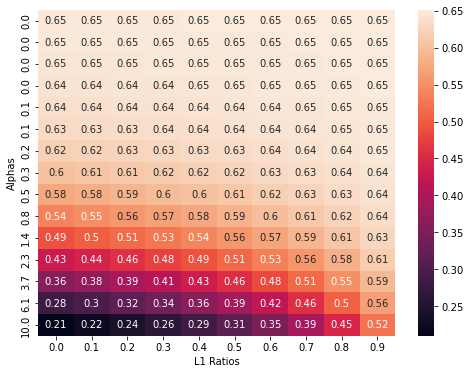

In [163]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

#setting up final pipeline
ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('cont', SimpleImputer(strategy='median'),
                         cont_cols + ['cluster_0', 'cluster_1', 'cluster_2'])])

#Need to scale features so they have similar weights during regulization
model = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', ElasticNet())])


#now will use Elastic Net to compare results
#tuning params with MultiFidelity approach, subsample to find performance envelope
y_multifidel = y_train.sample(frac=0.1)
X_multifidel = X_train.loc[y_multifidel.index, :]
x_train_kmeans, _ = extract_clusters(X_multifidel, X_test, KMeans(n_clusters=3))
#setting search grid for alphas and 
alphas = np.logspace(-2, 1, num=15)
l1_ratio = np.arange(0, 1, 0.1)
grid_param = {'model__alpha' : alphas,
              'model__l1_ratio': l1_ratio}

grid = GridSearchCV(model, grid_param, n_jobs=-1)
grid.fit(x_train_kmeans, y_multifidel)

grid_results = grid.cv_results_['mean_test_score'].reshape(len(alphas), -1)
fig,ax=plt.subplots(figsize=(8,6))
sns.heatmap(grid_results, annot=True, yticklabels=alphas.round(1), xticklabels=l1_ratio.round(1), ax=ax)
ax.set_xlabel('L1 Ratios')
ax.set_ylabel('Alphas')

From the heatmap the model performs better without regulazation (low alpha) and at some point L1 Ratio stops to matter

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37011990748.179504, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37475603577.288086, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37251555129.1944, tolerance: 231360793.48685113
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Ca

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11167286502.952759, tolerance: 229627813.20115396
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1493387230.7768555, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1499555197.2996826, tolerance: 232585300.2252964
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/homebrew/C

{'model__alpha': 0.01}


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:607: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46278277872.197876, tolerance: 289285277.0143621
  model = cd_fast.sparse_enet_coordinate_descent(


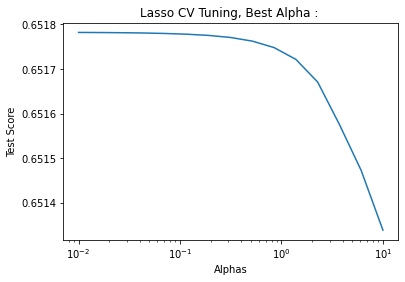

In [164]:
from sklearn.linear_model import Lasso

model.steps[2] = ('model', Lasso())
alphas = np.logspace(-2, 1, 15)
grid = GridSearchCV(model, param_grid={'model__alpha':alphas}, n_jobs=-1)
grid.fit(x_train_kmeans, y_multifidel)

plt.plot(alphas, grid.cv_results_['mean_test_score'])
plt.title('Lasso CV Tuning, Best Alpha : ')
plt.xscale('log')
plt.xlabel('Alphas')
plt.ylabel('Test Score')
print(grid.best_params_)

In [167]:
#no will score Lasso and Linear Regression to compare the results
from sklearn.model_selection import cross_validate

lr_model = Pipeline([('ct', ct), ('model', LinearRegression())])
lasso_model = Pipeline([('ct', ct), 
                        ('scaler', StandardScaler(with_mean=False)),
                        ('model', ElasticNet(alpha=0.1, l1_ratio=0.9))])

x_train_kmeans, x_test_kmeans = extract_clusters(X_train, X_test, KMeans(n_clusters=3))
lr_model.fit(x_train_kmeans, y_train)
lr_score = lr_model.score(x_test_kmeans, y_test)
lasso_model.fit(x_train_kmeans, y_train)
lasso_score = lasso_model.score(x_test_kmeans, y_test)
print(f'LR Score: {lr_score:.3f} \nLasso Score: {lasso_score:.3f}')

LR Score: 0.705 
Lasso Score: 0.704
